In [1]:
import logging
from pathlib import Path
import json
import copy

# Load the relevant libraries (all available from anaconda)
import geojson
import networkx as nx
from shapely.geometry import Point, MultiPoint, Polygon, MultiPolygon, LineString
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from tqdm.notebook import tqdm
import pyproj
import shapely
import requests

# This a small library that is included. These might move to a seperate repo.
from dtv_backend.network.pyFIS import pyFIS
import dtv_backend.network.build_network_functions as bnf
import dtv_backend.network.network_utilities 


version = '0.3'
# %matplotlib inline

In [2]:
# Enable logging messages
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)

In [3]:
# store results in this folder
outputdir = Path('result')
assert outputdir.exists()

# Get data from FIS
In this section we extract data from vaarweginformatie.nl using the pyFIS library. 

### FIS calls and processing

In [4]:
# Connect to FIS
FIS = pyFIS()

In [5]:
# Get all section (=vaarwegvakken) and properties from FIS
section = FIS.list_objects('section')   # TODO: Do not keep all columns
maximumdimensions = FIS.list_objects('maximumdimensions')
navigability = FIS.list_objects('navigability') 

Removing 4 nan-geometries from dataset


In [6]:
maximumdimensions_columns = [
    'Id', 'GeneralDepth', 'GeneralLength', 'GeneralWidth', 'Note',
    'SeaFairingDepth', 'PushedLength',
    'PushedWidth', 'GeneralHeight', 'SeaFairingLength', 'SeaFairingWidth',
    'CoupledLength', 'CoupledWidth', 'PushedDepth', 'WidePushedDepth',
    'CoupledDepth', 'WidePushedLength', 'WidePushedWidth',
    'SeaFairingHeight'
]

navigability_columns = ['Id', 'Classification', 'Code', 'Description']

# Merge data of all three datasets

## This did not work out
## section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_maximumdimensions'))
## section = section.merge(navigability[navigability_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_navigability'))

# This is very slow.
ids = tuple(section.Id.values)
section['maximumdimensions_id'] = FIS.get_object_subobjects_list('section', ids, 'maximumdimensions')
section['navigability_id'] = FIS.get_object_subobjects_list('section', ids, 'navigability')

section = section.merge(maximumdimensions[maximumdimensions_columns], left_on='maximumdimensions_id', right_on='Id', how='left', suffixes=('', '_maximumdimensions'))
section = section.merge(navigability[navigability_columns], left_on='navigability_id', right_on='Id', how='left', suffixes=('', '_navigability'))


# Add property length
# section['length'] = section.length.values

# Remove sections that do not have an ID as start or end point (in the selection polygon this is only the end of the Linge)
# Alternative: Make up new node names for these locations and also add those locations to the section_node table
section = section[~section[['StartJunctionId', 'EndJunctionId']].isna().any(axis=1)]

section = section.set_index('Id')
section_drop_columns = [
    'GeoGeneration', 'VinCode', 'Direction', 'RouteKmEnd', 
    'RouteKmBegin', 'TypeId', 'FairwayId', 
    'RouteId', 'ForeignCode', 'maximumdimensions_id', 
    'navigability_id', 'Id_maximumdimensions', 'Note'
]
section = section.drop(section_drop_columns, axis=1, errors='ignore')

section.to_file(outputdir / 'FIS_section.geojson', driver='GeoJSON')

100%|██████████████████████████████████████████████████████████████████████████████████████████| 4668/4668 [00:05<00:00, 824.71it/s]


In [7]:
# Get nodes from FIS --> Not using these, some strange inconsistencies with the sections...
# section_node = FIS.list_objects('sectionjunction').set_index('Id')

node_start_columnname="StartJunctionId"
node_end_columnname="EndJunctionId"

all_active_section_nodes = pd.Series(section[node_start_columnname].to_list() + section[node_end_columnname].to_list()).unique()
section_node = bnf.create_nodes_from_geodataframe(all_active_section_nodes, section)

section_node.to_file(outputdir / 'FIS_section_node_manual.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [8]:
# Get all bridges including openings
bridges = FIS.merge_geotypes('bridge', 'opening')

bridge_columns = ['Id', 'Name', 'NumberOfOpenings', 'HeightClosed', 'CanOpen', 'geometry']
bridges = bridges[bridge_columns]

bridges_grouped = bnf.group_subobjects(bridges, fieldname='HeightClosed')

bridges.to_file(outputdir / 'FIS_bridges.geojson', driver='GeoJSON')
bridges_grouped.to_file(outputdir / 'FIS_bridges_grouped.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [9]:
# Get all locks including chambers
locks = FIS.merge_geotypes('lock', 'chamber')

locks_columns = ['Id', 'Name', 'geometry', 'NumberOfChambers', 'Length_chamber', 'Width_chamber']
locks = locks[locks_columns]

locks_grouped = bnf.group_subobjects(locks, fieldname='Id')

locks.to_file(outputdir / 'FIS_locks.geojson', driver='GeoJSON')
locks_grouped.to_file(outputdir / 'FIS_locks_grouped.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [10]:
# Get all structures and their openings
structures = FIS.merge_geotypes('exceptionalnavigationalstructure', 'opening').set_index('Id')

# Rename type to readable names
structures['StructureType'] = structures['StructureType'].replace({
    'ADT': 'Aquaduct',
    'GDK': 'Grondduiker',
    'KBK': 'Noodkering',
    'KBL': 'Kabel',
    'KSS': 'Keersluis',
    'ONB': 'Onbekend??',
    'PIL': 'Pijpleiding',
    'STW': 'Stuw',
    'SVK': 'Stormvloedkering',
    'TNL': 'Tunnel',
    'TSB': 'Transportleiding',
    'VKW': 'Voormalig kunstwerk'
})

# Select only the blocking structures
structures = structures[structures['StructureType'].isin(['Keersluis', 'Stuw', 'Stormvloedkering'])]

# Only keep these columns for now
structures_columns = ['Name', 'geometry', 'StructureType']
structures = structures[structures_columns]

structures.to_file(outputdir / 'FIS_structures.geojson', driver='GeoJSON')

In [11]:
# Get all berths from FIS
berth = FIS.list_objects('berth').set_index('Id')

# Get only berths marked as 'Overnachtingshaven' (not loading/unloading)
berth = berth.loc[[('OVERNIGHT_ACCOMODATION' in c) for c in berth['Category']]]

# Convert polygons to points
berth['geometry'] = berth.geometry.centroid

berth_grouped = berth.dissolve(by=['RouteId', 'RouteKmBegin'], aggfunc={
    'GeoType': len, 
    'Length': np.max,
    'Width': np.max,
    'MaximalShipLength': np.max,
    'Name': 'first'
})

# Only keep these columns
berth_columns = ['Name', 'geometry', 'Length', 'Width', 'MaximalShipLength']
berth = berth[berth_columns]

berth_grouped = berth_grouped.rename({'GeoGeneration': 'NumberOfBerths'}, axis=1)
berth_grouped.index = [f'Berth{ii}' for ii in range(berth_grouped.shape[0])]
berth_grouped.geometry = berth_grouped.centroid

berth.to_file(outputdir / 'FIS_berth.geojson', driver='GeoJSON')
berth_grouped.to_file(outputdir / 'FIS_berth_grouped.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


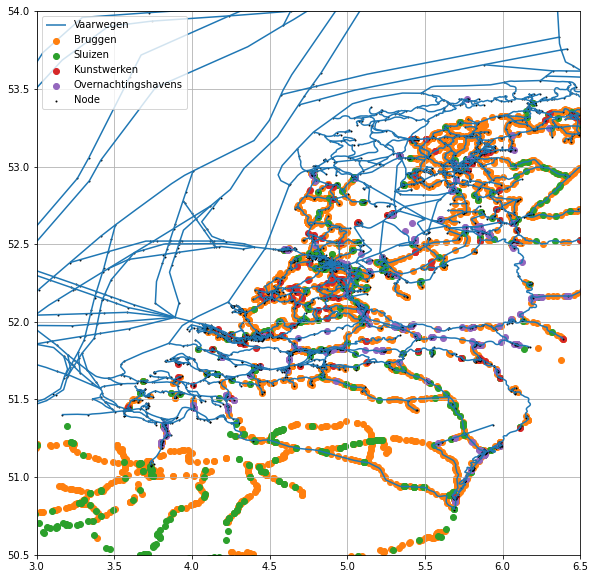

In [12]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(14,10))
section.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# Zoom to NL
plt.xlim(3, 6.5)
plt.ylim(50.5, 54);

plt.savefig(outputdir / 'FIS_NL.png', dpi=150, bbox_inches='tight')
plt.show()

### Expand with foreign Network

In [13]:
# Load Fairway for foreign network
fairway = FIS.list_objects('fairway').set_index('Id')
fairway.index = [f'F{f}' for f in fairway.index]             

# Remove Dutch network (nans)
fairway = fairway.loc[~fairway['ForeignCode'].isna()]

# Remove where FairwayNumber isna. This deletes some crappy data...
# fairway = fairway.loc[~fairway['FairwayNumber'].isna()]


# Add columns from other fairway objects
# --> Disabled, no additional data available for foreign network
# fairwayclassification = FIS.list_objects('fairwayclassification')
# fairwaydepth = FIS.list_objects('fairwaydepth') 
# fairwaystatus = FIS.list_objects('fairwaystatus') 

# fairwayclassification_columns = ['geometry', 'Type', 'TypeDescription']
# fairwaydepth_columns = ['geometry', 'MinimalDepthLowerLimit', 'MinimalDepthUpperLimit', 'ReferenceLevel']
# fairwaystatus_columns = ['geometry', 'TrajectCode', 'StatusCode', 'StatusDescription']


# fairway = fairway.merge(fairwayclassification[fairwayclassification_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwayclassification'))
# fairway = fairway.merge(fairwaydepth[fairwaydepth_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaydepth'))
# fairway = fairway.merge(fairwaystatus[fairwaystatus_columns], left_on='geometry', right_on='geometry', how='left', suffixes=('', '_fairwaystatus'))

# Add Length column and filter very small branches
fairway['length_deg'] = fairway.geometry.length
max_distance = 0.005
fairway = fairway.loc[fairway['length_deg'] > max_distance]

fairway_drop_columns = ['Direction', 'FairwayNumber', 'VinCode',  'RouteId', 'RouteKmBegin', 'RouteKmEnd', 'GeoGeneration', 'ForeignCode',]
fairway = fairway.drop(fairway_drop_columns, axis=1)

In [14]:
# The following code will process the fairway files to find all intersection, construction 
# a network from it with ID's to all start and end point

fairway = bnf.find_crossings_in_branches(fairway)

fairway['length_deg'] = fairway.geometry.length  # Update length for new branches
fairway.to_file(outputdir / 'FIS_fairway.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


In [15]:
# Extract start/end-nodes from fairways
all_nodes = np.unique(fairway[node_start_columnname].to_list() + fairway[node_end_columnname].to_list())
fairway_nodes = bnf.create_nodes_from_geodataframe(all_nodes, fairway)
fairway_nodes.to_file(outputdir / 'FIS_fairway_nodes.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


### Merge inland and foreign network

In [16]:
# This code will link the network of section and fairway together by renaming nodes in fairway
rename = {}
for n, point in fairway_nodes.items():
    nearby_points = bnf.all_points_in_radius(point, section_node.geometry.values, radius=max_distance)
    if len(nearby_points) > 0:
        logger.debug(f'Found a match{n}, section_node.iloc[nearby_points].index')
        rename[n] = section_node.index[nearby_points[0]]  # Rename to first point
        
fairway[[node_start_columnname, node_end_columnname]] = fairway[[node_start_columnname, node_end_columnname]].replace(rename)

In [17]:
# Merge fairway and section

section_fairway = pd.concat([section, fairway], axis=0, sort=False)
section_fairway_node = pd.concat([section_node, fairway_nodes], axis=0, sort=False)

section_fairway.reset_index().to_file(outputdir / 'FIS_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'FIS_section_fairway_node.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


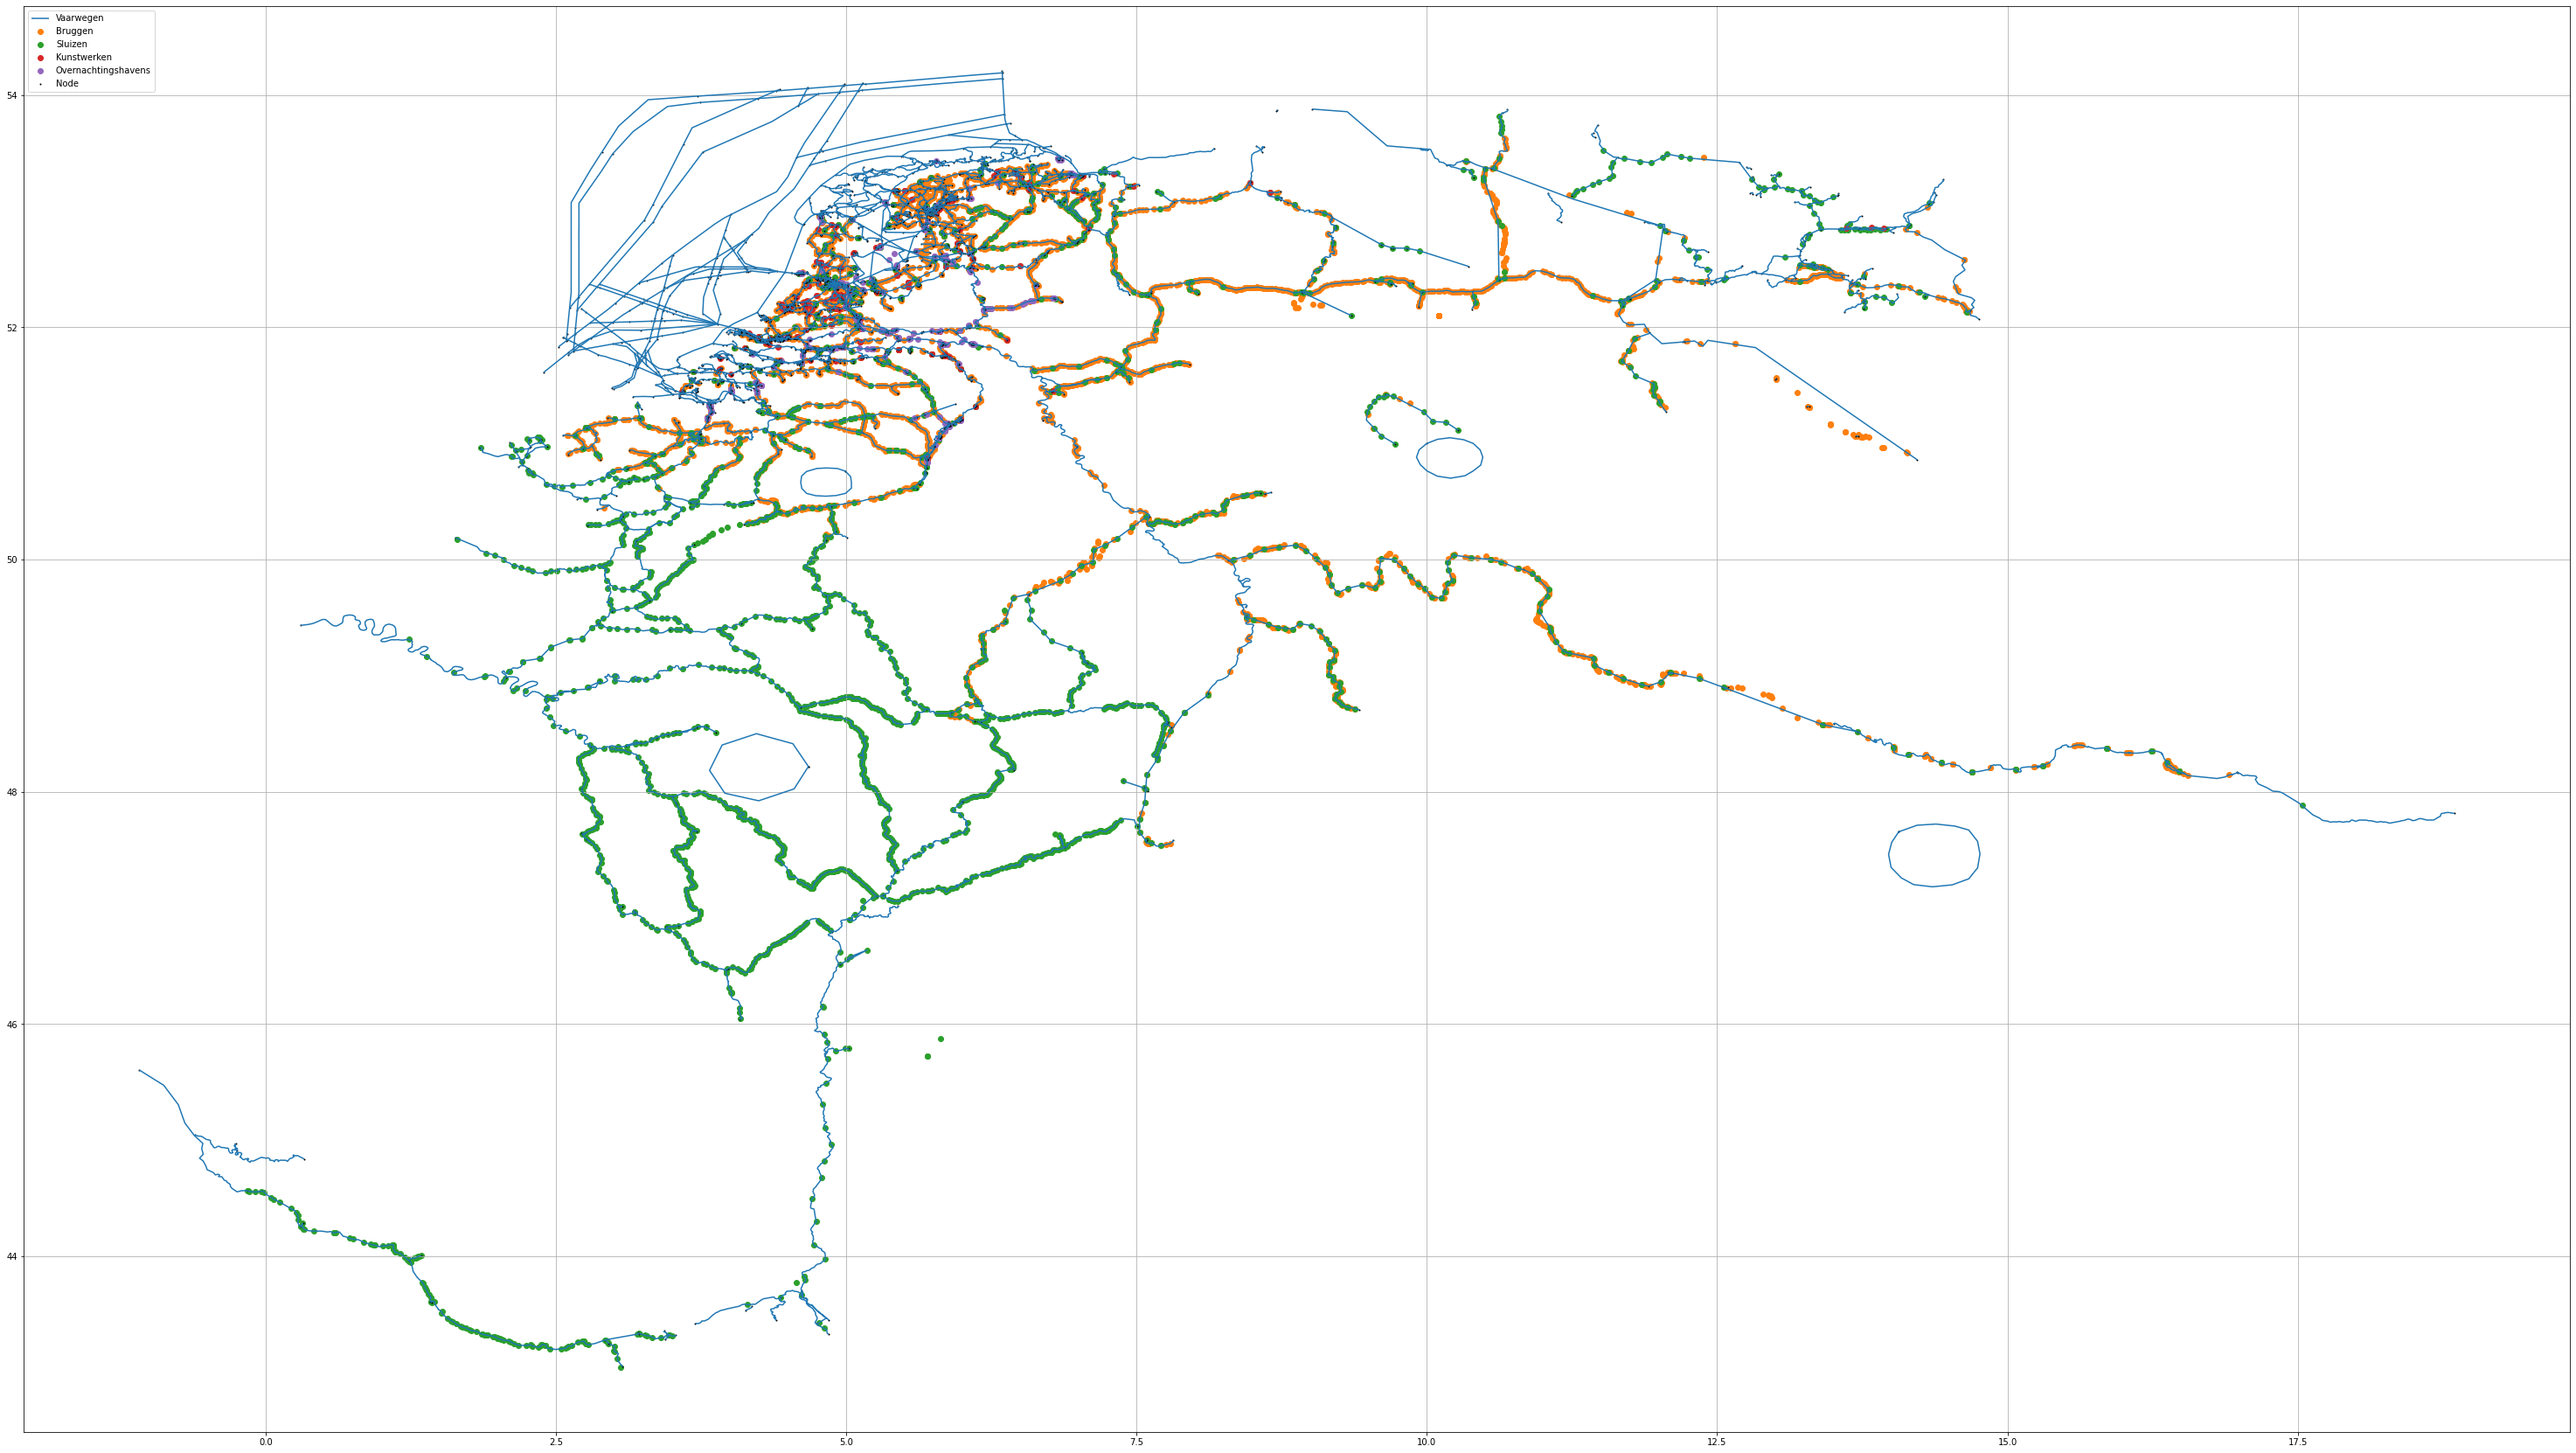

In [18]:
# Create plot to see what data we've loaded
f, ax  = plt.subplots(figsize=(70,30))
section_fairway.plot(color='C0', ax=ax, label='Vaarwegen')
bridges.plot(c='C1', ax=ax, label='Bruggen')
locks.plot(c='C2', ax=ax, label='Sluizen')
structures.plot(c='C3', ax=ax, label='Kunstwerken')
berth.plot(c='C4', ax=ax, label='Overnachtingshavens')
section_fairway_node.plot(color='k', ax=ax, markersize=1, label='Node')
ax.grid()
plt.legend(loc='upper left')

# plt.xlim(3, 8)
# plt.ylim(47, 54);
# plt.savefig()

plt.savefig(outputdir / 'FIS_Totaal.png', dpi=150, bbox_inches='tight')
plt.show()

# Split network at branches
There can be several locations on branches. We split the network at these locations so that you can include logic to pass a lock, pass below a bridge. In the discrete event simulation or navigation this helps to optimize computations. 

In [19]:
# Split branches at all bridges, locks and structures and create a new branch with a specific length
section_fairway = bnf.split_lines_around_points(section_fairway, bridges_grouped, max_distance=0.002, prefix='B', geotype='bridge', dx=0.0001)
section_fairway = bnf.split_lines_around_points(section_fairway, locks_grouped, max_distance=0.002, prefix='L', geotype='lock', dx=0.0004)
section_fairway = bnf.split_lines_around_points(section_fairway, structures, max_distance=0.002, prefix='S', geotype='structure', dx=0.0001)

  0%|          | 0/2874 [00:00<?, ?it/s]

  0%|          | 0/2763 [00:00<?, ?it/s]

  0%|          | 0/169 [00:00<?, ?it/s]

In [20]:
# Split branches at all berth, creating a new node
section_fairway = bnf.split_lines_at_points(section_fairway, berth_grouped, max_distance=0.002, prefix='')

  0%|          | 0/306 [00:00<?, ?it/s]

In [39]:
# Create nodes from coordinates of branches
all_nodes = pd.Series(section_fairway[node_start_columnname].to_list() + section_fairway[node_end_columnname].to_list()).unique()
section_fairway_node = bnf.create_nodes_from_geodataframe(all_nodes, section_fairway)

In [41]:
# Export final data to geojson
section_fairway.reset_index().to_file(outputdir / 'network_section_fairway.geojson', driver='GeoJSON')
section_fairway_node.to_file(outputdir / 'network_section_fairway_node.geojson', driver='GeoJSON')

/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,
/Users/baart_f/.virtualenvs/main/lib/python3.9/site-packages/geopandas/io/file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


# Build network
Based on the geometry we can now define a more abstract graph. A graph representation is similar to a subway map. It does not store the exact locations but it does store the topological relations between all the locations. 

In [59]:
def build_network(section_selection_with_bridges_with_locks):
    section_selection_with_bridges_with_locks['length'] = section_selection_with_bridges_with_locks.length.values
    section_selection_with_bridges_with_locks['Wkt'] = [a.wkt for a in section_selection_with_bridges_with_locks.geometry]
    section_selection_with_bridges_with_locks = section_selection_with_bridges_with_locks.drop('geometry', axis=1)
    
    network = nx.from_pandas_edgelist(section_selection_with_bridges_with_locks, 'StartJunctionId', 'EndJunctionId', edge_attr=True)
    for e, edge in network.edges.items():
        edge['StartJunctionId'] = e[0]
        edge['EndJunctionId'] = e[1]
        
    for n, node in network.nodes.items():
        node['n'] = n
        
    
    

    
    return network

network_includingHanging = build_network(section_fairway)

In [60]:
# Only keep the largest component (subgraph) and remove all disconnected subgraphs.
largest_component = max(nx.connected_components(network_includingHanging), key=len)
network = network_includingHanging.subgraph(largest_component).copy()

In [104]:
# add subgraph index, 0 is the largest
# There are general "country" graphs in the network
network = network_includingHanging
sorted_components = sorted(nx.connected_components(network_includingHanging), key=len, reverse=True)
for i, component in enumerate(sorted_components):
    network_i = network_includingHanging.subgraph(component)
    for e, edge in network_i.edges.items():
        edge['subgraph'] = i
        


In [105]:
# Add node properties
for n in network.nodes:
    network.nodes[n]['n'] = n
    network.nodes[n]['X'] = section_fairway_node.loc[n].x
    network.nodes[n]['Y'] = section_fairway_node.loc[n].y
    network.nodes[n]['geometry'] = '{}'.format(Point(section_fairway_node.loc[n].x, section_fairway_node.loc[n].y))

In [106]:
# The network version 0.1 contains the lat/lon distance in a length property.
# But we need the "great circle" or projected distance.
# Let's define a function to recompute it.



network = dtv_backend.network.network_utilities.add_geometries(network)

In [107]:
# Some stats
print(nx.classes.function.info(network))

Graph with 15584 nodes and 16164 edges


# Serialize
The network will be stored in different output forms:
- pickle: for performance
- json: for web / humans
- shapefile: for gis

In [108]:
nx.write_gpickle(network, outputdir / f'network_digital_twin_v{version}.pickle')

In [109]:
# store the result as json (no)
data = nx.readwrite.json_graph.node_link_data(network)
with open(outputdir / f'network_digital_twin_v{version}.json', 'w') as fout:
    json.dump(data, fout)

In [110]:
shp_network = bnf.strip_geometries(bnf.rename_keys(network))
nx.write_shp(shp_network, str(outputdir / f'network_digital_twin_v{version}'))

/var/folders/fh/tcbrjg6n28b0lzjzh07b5t6m0000gn/T/ipykernel_50978/2150131222.py:2: DeprecationWarning: write_shp is deprecated and will be removed in 3.0.See https://networkx.org/documentation/latest/auto_examples/index.html#geospatial.
  nx.write_shp(shp_network, str(outputdir / f'network_digital_twin_v{version}'))


In [70]:
#  now upload this shape file to GEE and run the fis-bathy script
! open $outputdir

# Visualize

(-1.6468339440663162, 20.796816155471497, 42.18822345375908, 55.34959350746022)

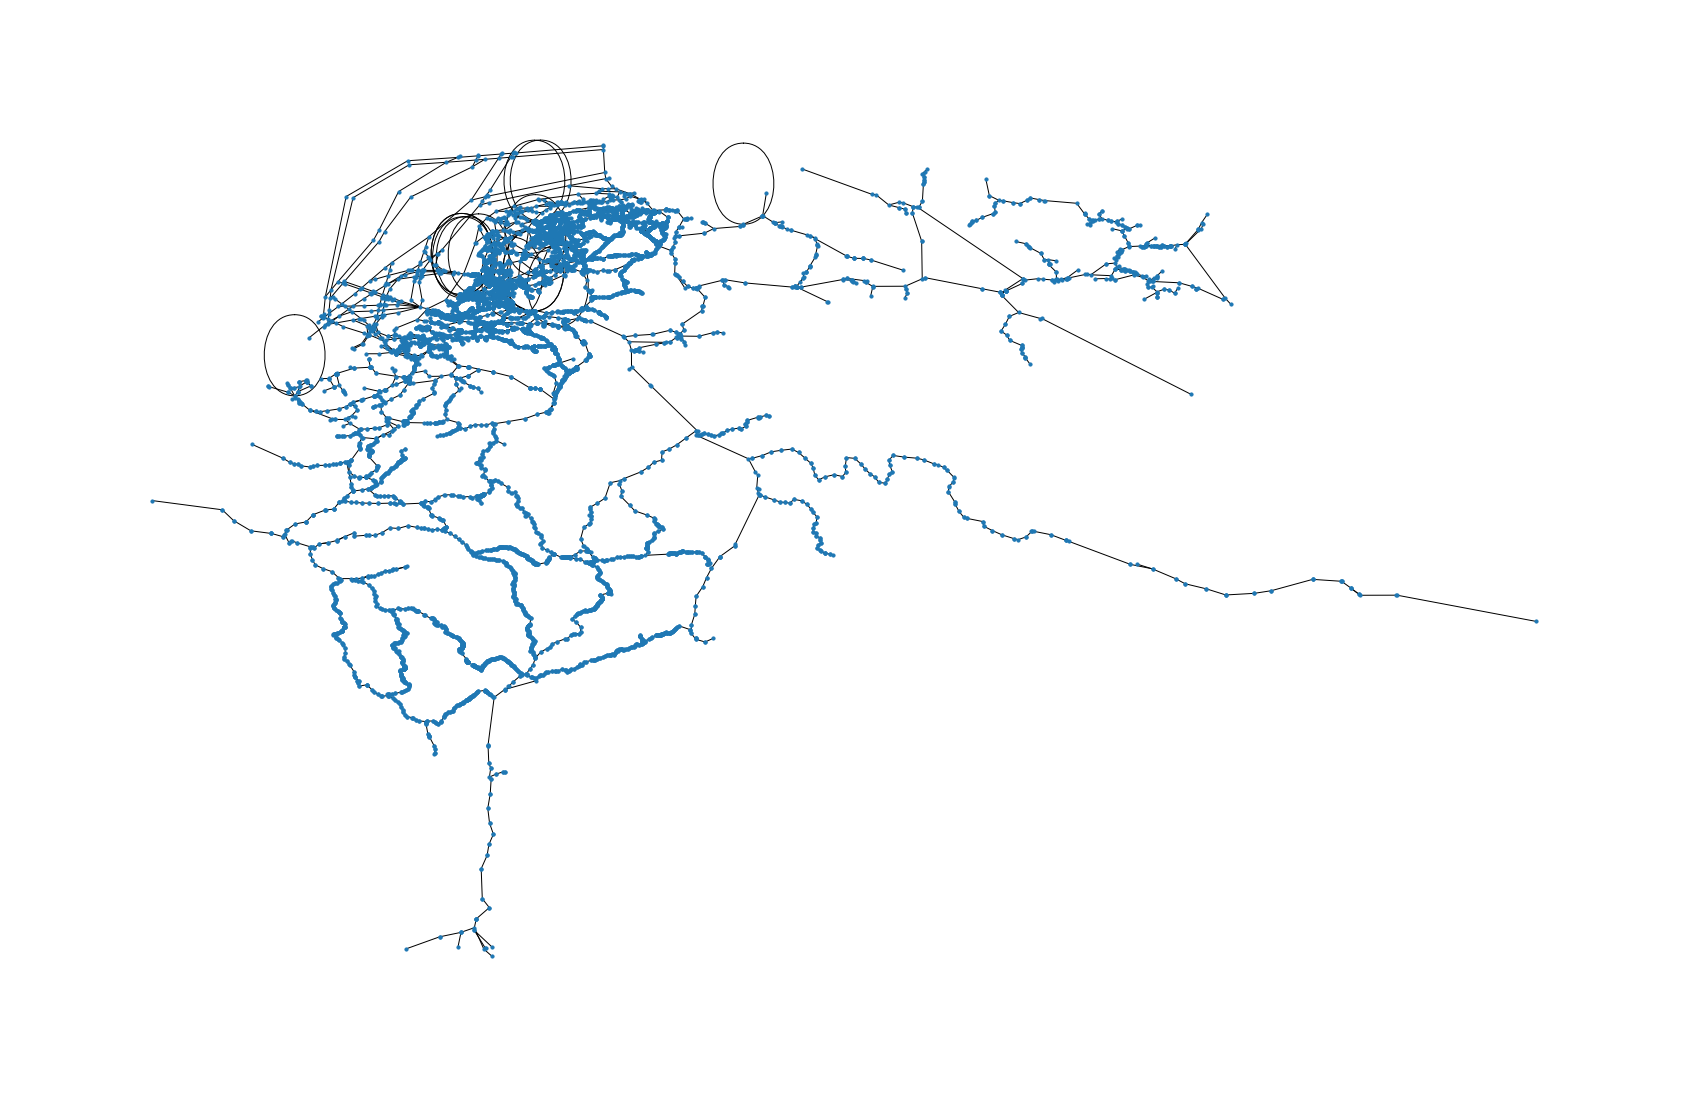

In [82]:
# this is the subway version of the corridor
fig, ax = plt.subplots(figsize=(30, 20))

spatial_pos = {
    k: (v['X'], v['Y']) 
    for k, v 
    in network.nodes.items()
}
nx.draw(
    network, 
    pos=spatial_pos, 
    node_size=10,
    ax=ax
)
ax.axis('equal')

